In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

## 1. IMPORTING MARKET, ASSETS AND FACTORS DATA

In [4]:
industry_raw = pd.read_excel('Industry_Portfolios.xlsx')
industry_raw = industry_raw.set_index('Date')
industry_raw.index = pd.to_datetime(industry_raw.index, format = '%Y%m')
industry_raw.index = industry_raw.index.to_period('M')
industry_raw.head(2)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
2004-01,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
2004-02,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16


In [6]:
market_raw = pd.read_excel('Market_Portfolio.xlsx')
market_raw =  market_raw.set_index('Date')
market_raw.index = pd.to_datetime(market_raw.index, format = '%Y%m')
market_raw.index = market_raw.index.to_period('M')
market_raw.head(2)

,Market
Date,
2004-01,2.22
2004-02,1.46


In [8]:
ff_3 = pd.read_excel('Risk_Factors.xlsx')
ff_3 =  ff_3.set_index('Date')
ff_3.index = pd.to_datetime(ff_3.index, format = '%Y%m')
ff_3.index = ff_3.index.to_period('M')
ff_3.head()

,Rf,Rm-Rf,SMB,HML
Date,,,,
2004-01,0.07,2.15,2.67,1.55
2004-02,0.06,1.40,-1.17,0.45
2004-03,0.09,-1.32,1.84,0.07
2004-04,0.08,-1.83,-2.59,-1.67
2004-05,0.06,1.17,-0.10,-0.33


In [12]:
df_merged = (ff_3.merge(market_raw, how = 'left', left_index = True, right_index = True)
             .merge(industry_raw, how = 'left', left_index = True, right_index = True))
df_merged.head()

,Rf,Rm-Rf,SMB,HML,Market,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,,,,,,
2004-01,0.07,2.15,2.67,1.55,2.22,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
2004-02,0.06,1.40,-1.17,0.45,1.46,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16
2004-03,0.09,-1.32,1.84,0.07,-1.23,-0.09,-1.15,-0.27,-0.13,-2.55,-2.07,0.29,-3.96,1.13,-0.63
2004-04,0.08,-1.83,-2.59,-1.67,-1.75,1.42,2.30,-0.17,2.52,-4.91,-0.48,-2.70,3.54,-3.55,-3.76
2004-05,0.06,1.17,-0.10,-0.33,1.23,-1.89,-1.64,1.61,0.39,4.85,-2.95,0.30,-0.42,1.28,1.86


### 2. RUN FACTOR (INDEX MODEL)
* Here we define a more comprehensive model compared to the classic CAPM models.
* The output includes the cofficients of the CAPM model as well as those for the factor models.
* Basically we can incorporate unlimited factors to run this developed function.

### 2.1. Get full model results

In [16]:
def factor_model_single(df: pd.DataFrame, asset_col: str, factors: list, rf_col: str = 'Rf', capm_factor: str = 'Market'):
    """
    Calculate the factor model (e.g., CAPM or multi-factor model) alpha and betas for a given asset.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing columns for asset returns, factors, and risk-free rates.
    - asset_col (str): The column name of the asset returns.
    - factors (list): List of factor column names (e.g., ['Market', 'SMB', 'HML']).
    - rf_col (str): The column name of the risk-free rates (default: 'Rf').
    - capm_factor (str): The column name for the CAPM market factor (default: 'Market').
    
    Returns:
    - dict: A dictionary containing CAPM Alpha, CAPM Beta, multi-factor alpha, betas for each factor, and the regression model summaries.
    """
    # Step 1: Calculate Excess Returns using the risk-free rate for the asset and each factor
    asset_excess_return = df[asset_col] - df[rf_col]
    factors_excess_return = df[factors].sub(df[rf_col], axis=0)
    capm_excess_return = df[capm_factor] - df[rf_col]
    
    # Step 2: Prepare Data for Regression
    data = pd.concat([asset_excess_return, factors_excess_return], axis=1).dropna()
    data.columns = ['Asset Excess Return'] + factors  # Rename columns for clarity
    
    # Step 3: Calculate CAPM Alpha and Beta (simple linear regression with the market factor)
    capm_data = pd.concat([asset_excess_return, capm_excess_return], axis=1).dropna()
    capm_data.columns = ['Asset Excess Return', 'Market Excess Return']
    
    X_capm = sm.add_constant(capm_data['Market Excess Return'])
    capm_model = sm.OLS(capm_data['Asset Excess Return'], X_capm).fit()
    capm_alpha = capm_model.params['const']  # CAPM Alpha
    capm_beta = capm_model.params['Market Excess Return']  # CAPM Beta

    # Step 4: Run the Multi-Factor Regression
    X_multi = sm.add_constant(data[factors])  # Predictor variables include the factors
    y = data['Asset Excess Return']           # Response variable is the asset's excess return
    
    multi_factor_model = sm.OLS(y, X_multi).fit()
    
    # Step 5: Extract Alpha (intercept) and Betas (slopes for each factor) from multi-factor model
    ff_alpha = multi_factor_model.params['const']
    betas = {factor: multi_factor_model.params[factor] for factor in factors}
    
    # Return results in a dictionary, including CAPM Alpha, CAPM Beta, and multi-factor model details
    return {
        'capm_alpha': round(capm_alpha, 4),
        'capm_beta': round(capm_beta, 4),
        'ff_alpha': round(ff_alpha, 4),
        'betas': {factor: round(betas[factor], 4) for factor in betas},
        'capm_model_summary': capm_model.summary(),
        'multi_factor_model_summary': multi_factor_model.summary()
    }
    

# 2. Run factor (index) model for multiple assets
def factor_model_mult(df: pd.DataFrame, asset_cols: list, factors: list, rf_col: str = 'Rf', capm_factor: str = 'Market'):
    """
    Run factor models (e.g., CAPM or multi-factor models) for multiple assets.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing columns for multiple asset returns, factors, and risk-free rates.
    - asset_cols (list): List of column names corresponding to the asset returns.
    - factors (list): List of factor column names (e.g., ['Market', 'SMB', 'HML']).
    - rf_col (str): The column name of the risk-free rates (default: 'Rf').
    - capm_factor (str): The column name for the CAPM market factor (default: 'Market').
    
    Returns:
    - dict: A dictionary containing factor model results for each asset (CAPM alpha/beta, multi-factor alpha/betas, and model summaries).
    """
    results = {}
    
    # Loop through each asset column in the list and calculate the factor model
    for asset_col in asset_cols:
        # Calculate alphas and betas for each asset, including both CAPM and multi-factor results
        results[asset_col] = factor_model_single(df, asset_col, factors, rf_col=rf_col, capm_factor=capm_factor)
    
    return results

In [18]:
asset_cols =  industry_raw.columns
factors =  ['Rm-Rf', 'SMB', 'HML']
ff_3_model = factor_model_mult(df_merged/100, asset_cols, factors, rf_col = 'Rf')

# Divide by 100 because the data is represented as % already, hence this step might be useful dependently

In [20]:
ff_3_model

{'NoDur': {'capm_alpha': 0.0037,
  'capm_beta': 0.6537,
  'ff_alpha': 0.0045,
  'betas': {'Rm-Rf': 0.7108, 'SMB': -0.2314, 'HML': -0.0202},
  'capm_model_summary': <class 'statsmodels.iolib.summary.Summary'>
  """
                               OLS Regression Results                            
  Dep. Variable:     Asset Excess Return   R-squared:                       0.719
  Model:                             OLS   Adj. R-squared:                  0.716
  Method:                  Least Squares   F-statistic:                     301.4
  Date:                 Thu, 14 Nov 2024   Prob (F-statistic):           2.77e-34
  Time:                         11:00:55   Log-Likelihood:                 313.64
  No. Observations:                  120   AIC:                            -623.3
  Df Residuals:                      118   BIC:                            -617.7
  Df Model:                            1                                         
  Covariance Type:             nonrobust        

### 2.2. Get the coefficients

In [23]:
# 3. Get the coefficients of the factor models, including those of CAPM
def factor_model_coeff(results):
    """
    Extract and organize the CAPM alpha/beta and multi-factor alpha/betas from the multi-factor model results.
    
    Parameters:
    - results: The dictionary of multi-factor model results returned by `factor_model_mult`.
    
    Returns:
    - pd.DataFrame: A DataFrame with CAPM alpha/beta, multi-factor alpha, and beta values for each asset and factor.
    """
    # Initialize a list to store each asset's coefficients
    coefficients = []
    
    # Iterate through the results dictionary to extract CAPM alpha/beta and multi-factor alpha/betas
    for asset, result in results.items():
        # Start with the asset's CAPM and multi-factor alpha and beta
        asset_data = {
            'Asset': asset,
            'CAPM_Alpha': result['capm_alpha'],
            'CAPM_Beta': result['capm_beta'],
            'FF_Alpha': result['ff_alpha']
        }
        
        # Add each factor's beta value to the dictionary
        for factor, beta in result['betas'].items():
            asset_data[f'{factor.upper()}_Coefficients'] = beta
        
        # Append the asset's coefficient data to the list
        coefficients.append(asset_data)
    
    # Convert the list of dictionaries to a DataFrame
    coefficients_df = pd.DataFrame(coefficients).set_index('Asset')
    
    return coefficients_df

In [25]:
ff_3_coeff = factor_model_coeff(ff_3_model)
ff_3_coeff

,CAPM_Alpha,CAPM_Beta,FF_Alpha,RM-RF_Coefficients,SMB_Coefficients,HML_Coefficients
Asset,,,,,,
NoDur,0.0037,0.6537,0.0045,0.7108,-0.2314,-0.0202
Durbl,-0.0042,1.6494,-0.0017,1.4418,0.6515,0.2507
Manuf,0.0016,1.1679,0.0032,1.1404,0.0681,0.0252
Enrgy,0.0050,0.9655,0.0062,1.0285,-0.2821,-0.0192
HiTec,-0.0006,1.1324,0.0005,1.1515,0.3201,-0.5599
Telcm,0.0019,0.9017,0.0031,0.9220,-0.0859,-0.0146
Shops,0.0027,0.8295,0.0039,0.7671,0.2778,-0.0298
Hlth,0.0024,0.6759,0.0031,0.7501,-0.2085,-0.1358
Utils,0.0045,0.5370,0.0050,0.6320,-0.3957,-0.0210


## 3. CALCULATING COMMON PERFORMANCE METRICS

In [29]:
betas_df =  ff_3_coeff[['CAPM_Beta']]

In [31]:
asset_cols

Index(['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'HiTec', 'Telcm', 'Shops', 'Hlth',
       'Utils', 'Other'],
      dtype='object')

In [41]:
# 1. Calculate performance metrics for a single asset (Note for Sortino we use n-1 and do not use only the number of positive values)
def performance_ratios_single(data: pd.DataFrame, asset: str, benchmark: str, rf_column: str, beta: float):
    """
    Calculate performance ratios for a single asset.
    
    Parameters:
    - data: DataFrame that contains asset returns, benchmark returns, and risk-free rate.
    - asset: The column name of the asset returns.
    - benchmark: The column name of the benchmark returns.
    - rf_column: The column name of the risk-free rate.
    - beta: The CAPM beta for the asset.
    
    Returns a dictionary containing the Sharpe ratio, Sortino ratio, Treynor ratio, Information ratio, and downside risk.
    """
    # Calculate excess returns over the risk-free rate
    excess_return_rf = data[asset] - data[rf_column]

    # Calculate Semi-deviation (below mean return)
    excess_mean = data[asset] - data[asset].mean()
    below_mean = excess_mean[excess_mean < 0]
    n_below_mean = len(below_mean)
    semi_var = (np.sum(below_mean**2)) / n_below_mean
    semi_dev = semi_var**0.5
    
    # Sharpe Ratio: (mean return - rf) / std deviation of returns
    sharpe_ratio = excess_return_rf.mean() / excess_return_rf.std()
    
    # Treynor Ratio: (mean return - rf) / beta
    treynor_ratio = excess_return_rf.mean() / beta
    
    # Information Ratio: (mean return - benchmark return) / tracking error
    excess_return_benchmark = data[asset] - data[benchmark]
    tracking_error = excess_return_benchmark.std()
    information_ratio = (excess_return_benchmark.mean()) / tracking_error if tracking_error != 0 else np.nan

    # Sortino Ratio: (mean return - benchmark return) / below-benchmark semi-deviation
    below_benchmark = excess_return_benchmark[excess_return_benchmark < 0]
    downside_var = (np.sum(below_benchmark**2)) / (len(data) - 1)
    downside_risk = downside_var**0.5
    sortino_ratio = (excess_return_benchmark.mean()) / downside_risk if downside_risk != 0 else np.nan
    
    # Return all the calculated ratios and downside risk
    return {
        'Semi Deviation': round(semi_dev, 4),
        'Sharpe Ratio': round(sharpe_ratio, 4),
        'Sortino Ratio': round(sortino_ratio, 4),
        'Treynor Ratio': round(treynor_ratio, 4),
        'Information Ratio': round(information_ratio, 4),
        'Downside Risk': round(downside_risk, 4)}


# 2. Calculate performance metrics for multiple assets
def performance_ratios_multiple(data: pd.DataFrame, assets: list, benchmark: str, rf_column: str, 
                                betas_df: pd.DataFrame, plot = False):
    """
    Calculate performance ratios for multiple assets.
    
    Parameters:
    - data: DataFrame that contains asset returns, benchmark returns, and risk-free rate.
    - assets: List of asset columns to calculate the performance ratios for.
    - benchmark: The column name of the benchmark returns.
    - rf_column: The column name of the risk-free rate.
    - betas_df: DataFrame containing each asset's beta with columns ['Asset', 'Beta'].
    - plot (bool): Plot the metrics as bar graphs
    
    Returns a DataFrame containing the performance ratios for each asset.
    """
    results = []

    # Ensure betas_df has a usable index for fast lookups
    betas_df.set_index('Asset', inplace=True)

    # Loop over each asset in the asset list
    for asset in assets:
        # Check if the asset has an associated beta in betas_df
        if asset in betas_df.index:
            # Retrieve the beta value for the asset
            beta = betas_df.loc[asset, 'CAPM_Beta']
            
            # Calculate the performance ratios for the asset
            metrics = performance_ratios_single(data, asset, benchmark, rf_column, beta)
            metrics['Asset'] = asset  # Add asset name for reference
            results.append(metrics)
    
    # Convert the list of results into a DataFrame
    results_df = pd.DataFrame(results)
    
    # Set the asset name as the index
    results_df.set_index('Asset', inplace=True)

    # Plot metrics if plot=True
    if plot:
        for metric in results_df.columns:
            plt.figure(figsize=(13, 6))
            bars = plt.bar(results_df.index, results_df[metric])
            
            # Add value labels on top of each bar
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')
            
            plt.title(f'{metric} for each asset', fontsize = 14, color = 'darkblue')
            plt.xlabel('Asset', fontsize = 12)
            plt.ylabel(metric, fontsize = 12)
            plt.xticks(rotation=45)
            plt.grid(True, alpha = 0.3)
            plt.tight_layout()
            plt.show()
    
    return results_df

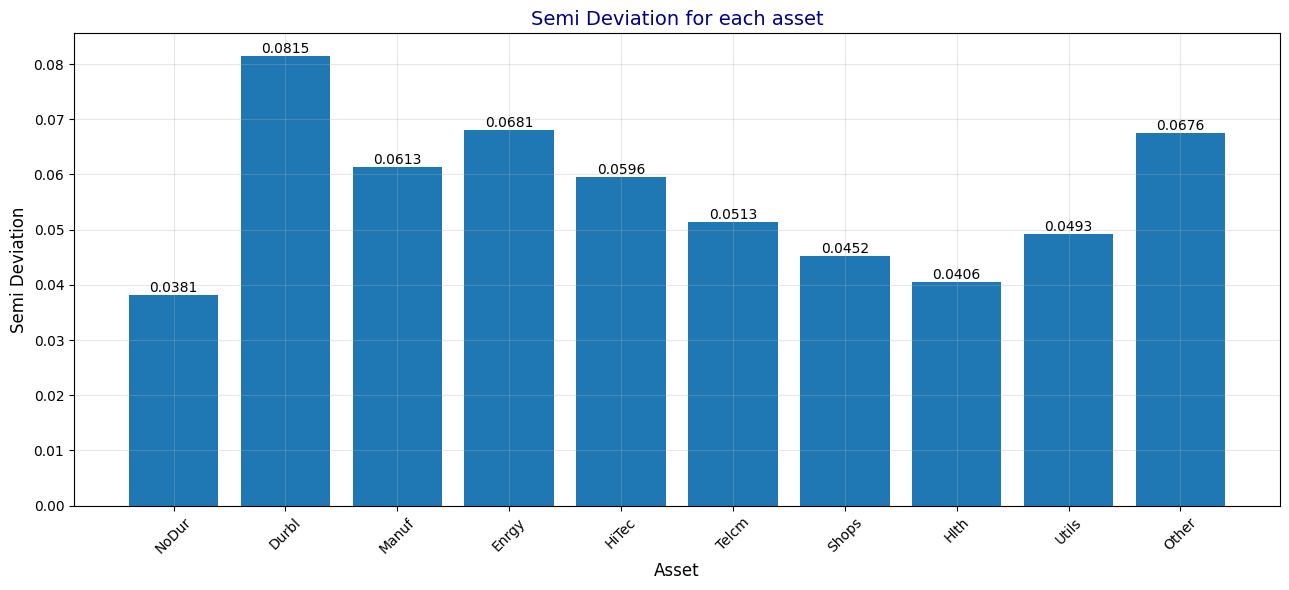

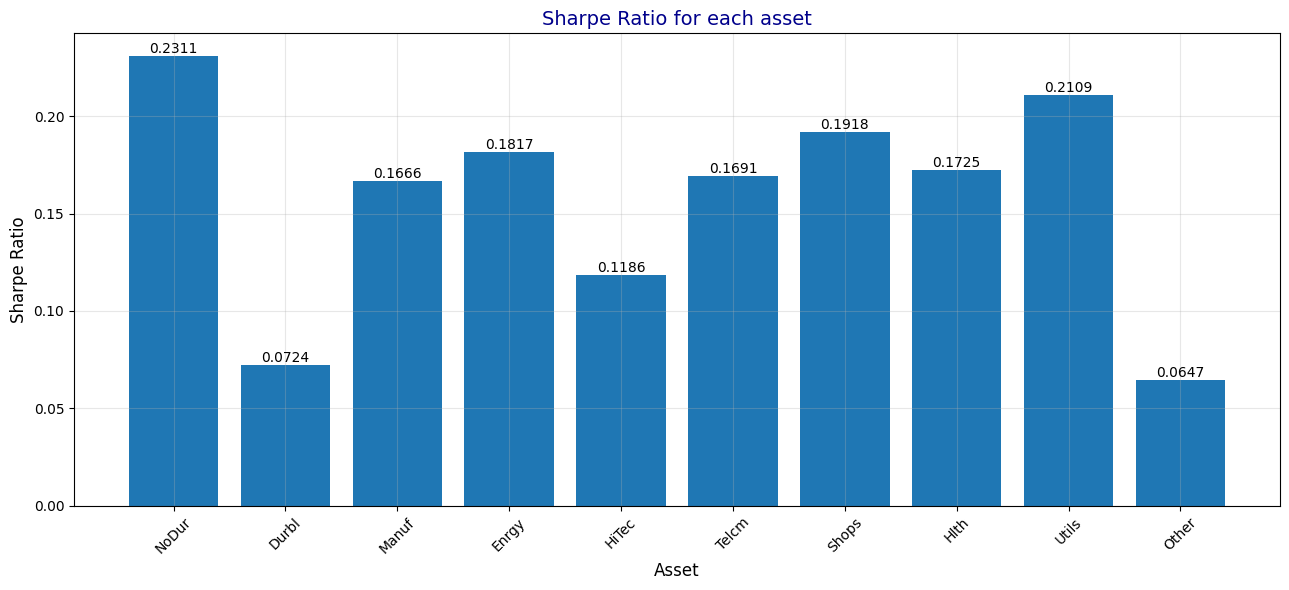

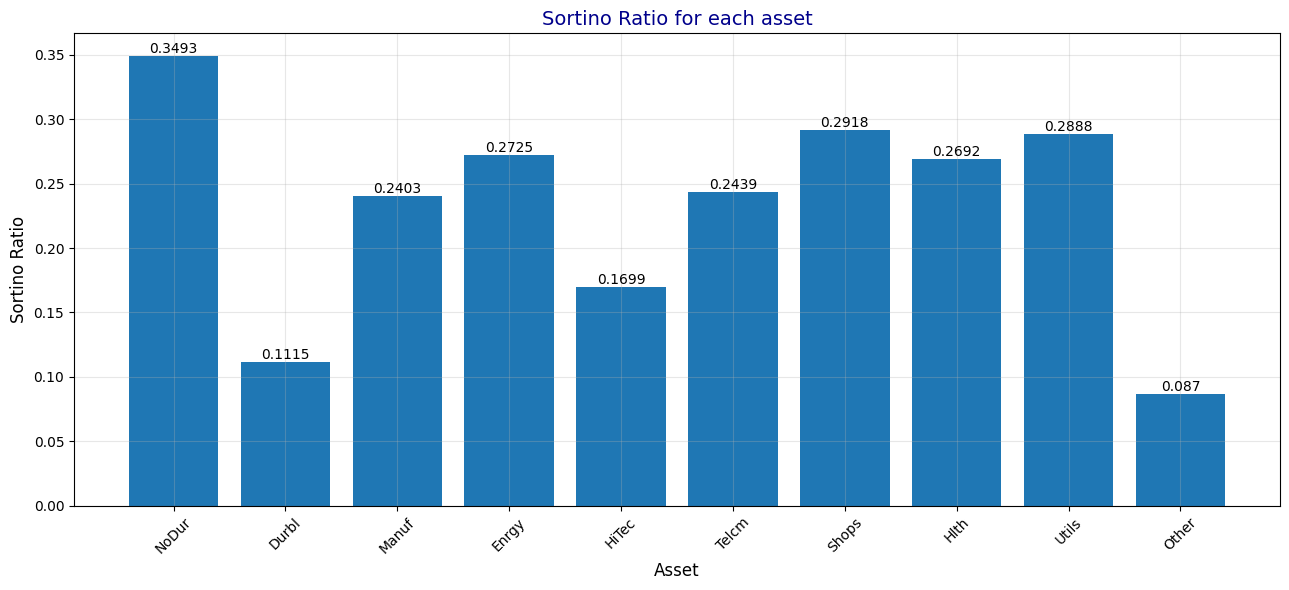

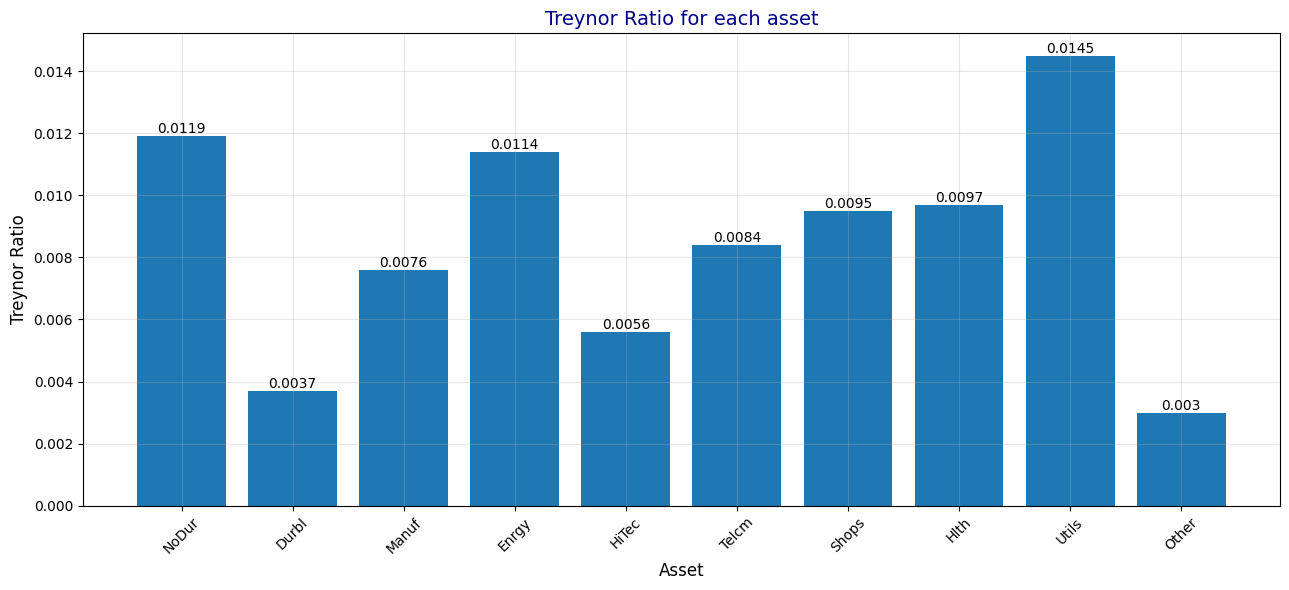

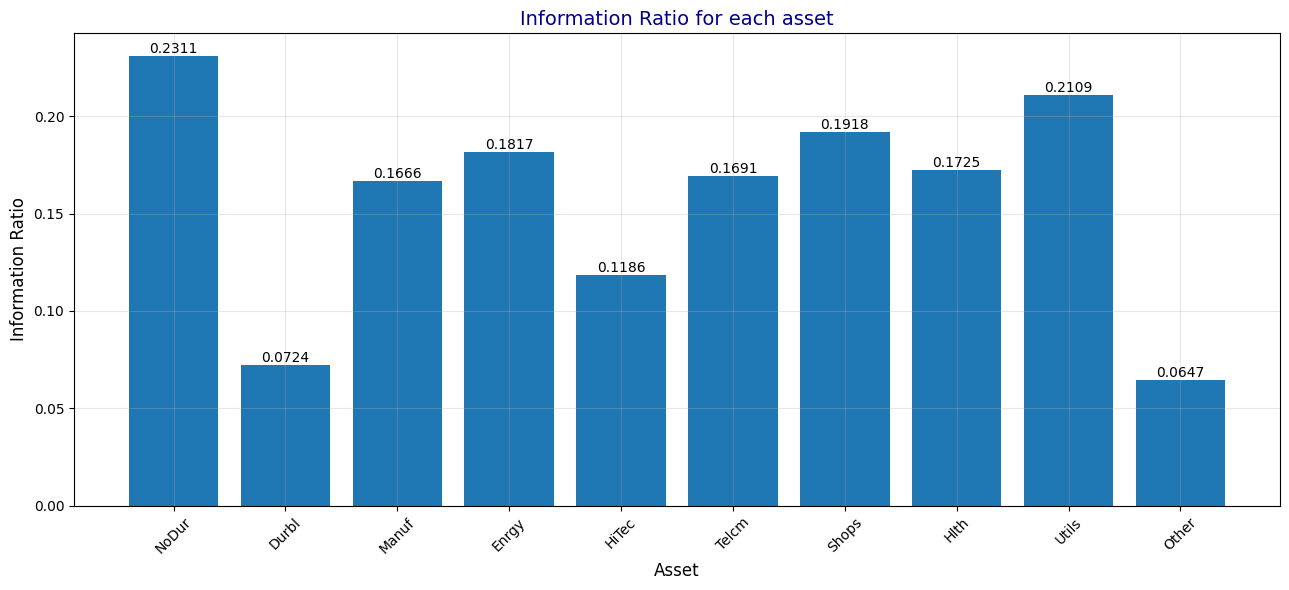

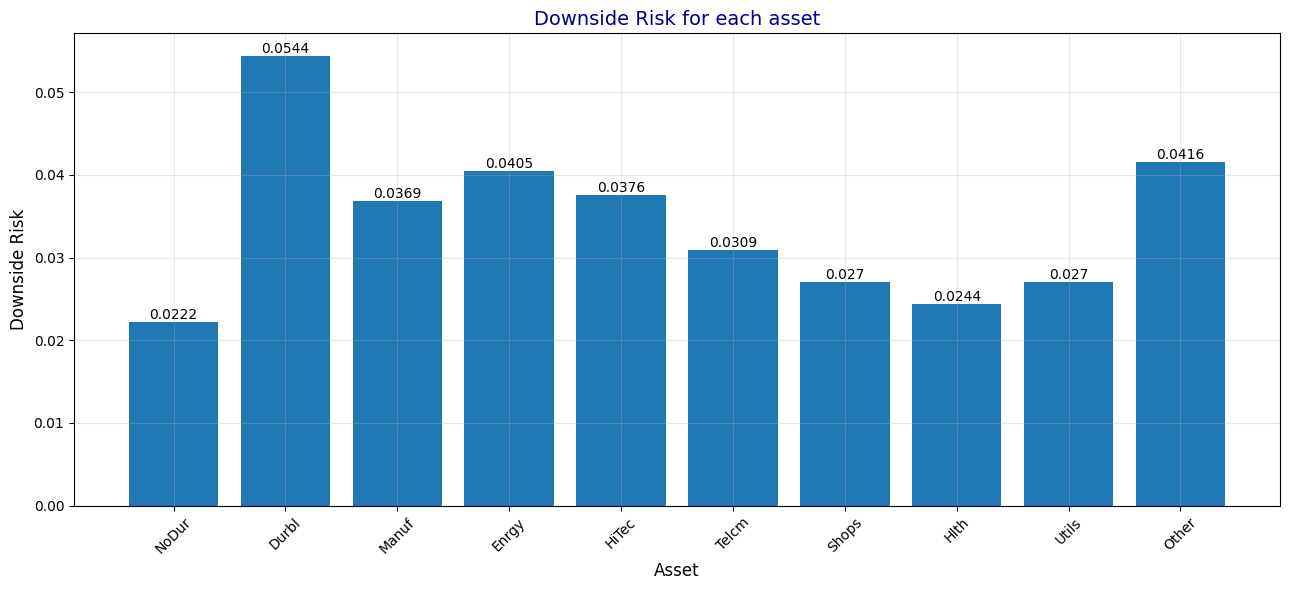

,Semi Deviation,Sharpe Ratio,Sortino Ratio,Treynor Ratio,Information Ratio,Downside Risk
Asset,,,,,,
NoDur,0.0381,0.2311,0.3493,0.0119,0.2311,0.0222
Durbl,0.0815,0.0724,0.1115,0.0037,0.0724,0.0544
Manuf,0.0613,0.1666,0.2403,0.0076,0.1666,0.0369
Enrgy,0.0681,0.1817,0.2725,0.0114,0.1817,0.0405
HiTec,0.0596,0.1186,0.1699,0.0056,0.1186,0.0376
Telcm,0.0513,0.1691,0.2439,0.0084,0.1691,0.0309
Shops,0.0452,0.1918,0.2918,0.0095,0.1918,0.0270
Hlth,0.0406,0.1725,0.2692,0.0097,0.1725,0.0244
Utils,0.0493,0.2109,0.2888,0.0145,0.2109,0.0270


In [43]:
metrics_df = (performance_ratios_multiple(
                  df_merged/100, asset_cols, benchmark = 'Rf', rf_column =  'Rf', 
    betas_df = betas_df.reset_index(), plot = True))

metrics_df

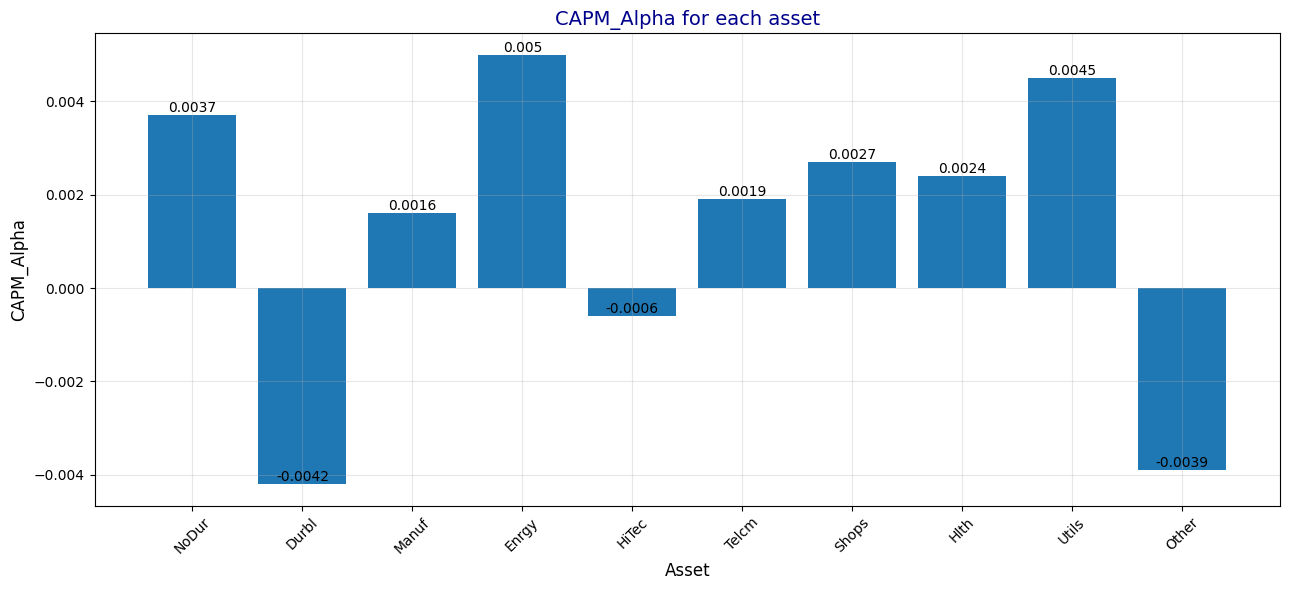

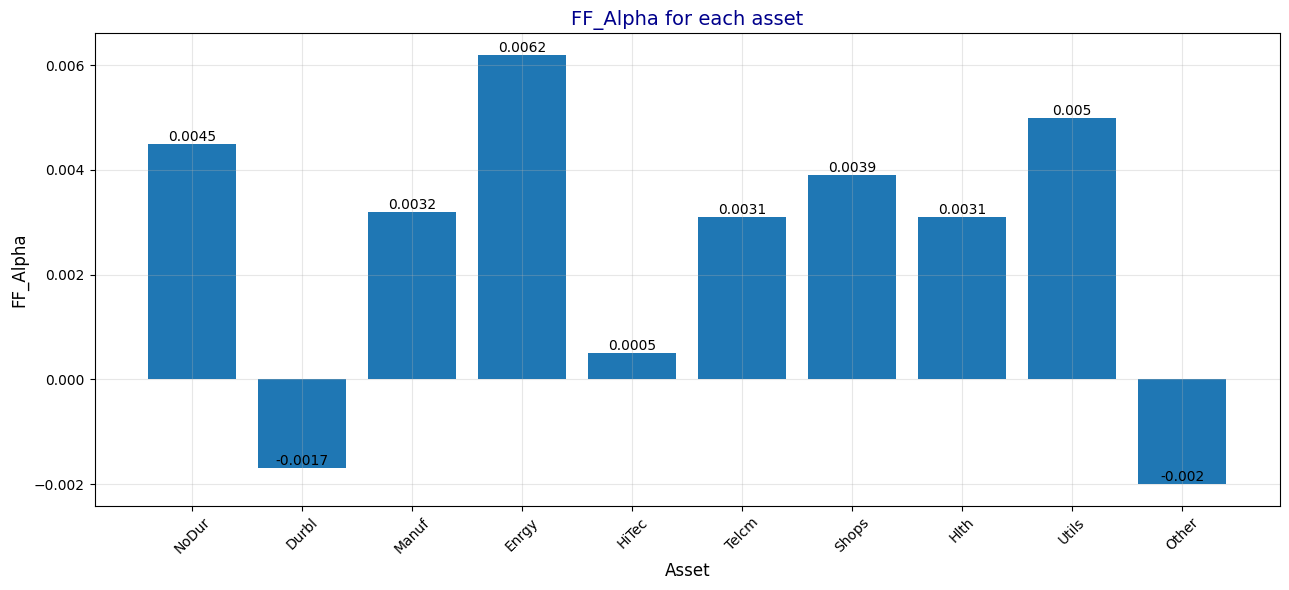

In [45]:
# Also plot Alpha for more information
columns_to_plot = ['CAPM_Alpha', 'FF_Alpha']

for column in columns_to_plot:
    plt.figure(figsize=(13, 6))
    bars = plt.bar(ff_3_coeff.index, ff_3_coeff[column])
    
    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')
    
    # Set titles and labels
    plt.title(f'{column} for each asset', fontsize=14, color='darkblue')
    plt.xlabel('Asset', fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha = 0.3)
    plt.tight_layout()
    plt.show()

* My gmail is binhnguyen.ibm@gmail.com
* For advance and complex models in practice, we can discuss for collaboration.
* Thank you.